<IPython.core.display.Javascript object>


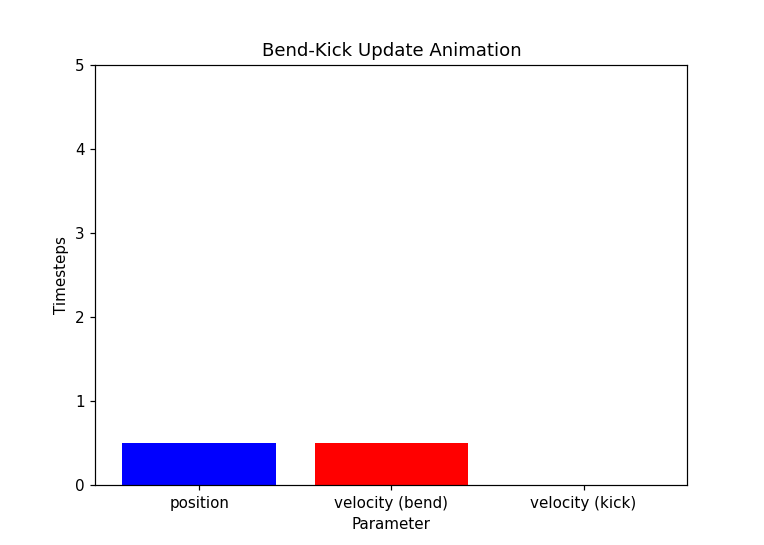

17


In [2]:
%matplotlib notebook
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, writers
import numpy as np
  
fig = plt.figure(figsize = (7,5))
axes = fig.add_subplot(1,1,1)
axes.set_ylim(0, 5)
palette = ['blue', 'red', 'maroon']
  
y1_arr = [0.5,0.5,0.5,1.5,1.5,1.5,2.5,2.5,2.5,3.5,3.5,3.5,4.5,4.5,4.5,5,5]
y2_arr = [0,0.5,0.5,0.5,1.5,1.5,1.5,2.5,2.5,2.5,3.5,3.5,3.5,4.5,4.5,4.5,5]
y3_arr = [0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5]
print(len(y3_arr))
  
def animation_function(i):
    y1 = y1_arr[i]
    y2 = y2_arr[i]
    y3 = y3_arr[i]

  
    plt.xlabel("Parameter")
    plt.ylabel("Timesteps")
      
    plt.bar(["position", "velocity (bend)", "velocity (kick)"],
            [y1, y2, y3],
            color = palette)
  
plt.title("Bend-Kick Update Animation")
  
animation = FuncAnimation(fig, animation_function, 
                          interval = 1000)
plt.show()

In [23]:
import numpy as np
n = 37
S = int((np.sqrt(9 - 12 * (1 - n)) - 3) / 6)
S

3

In [61]:
def generate_2D_hex_lattice(shells=1, scale=1):
        """Generate closed shell hexagonal lattice with shells and scale spacing.

        :param scale: scales lattice
        :return: a flattened xy position vector defining the 2d hexagonal lattice.
        """
        posvect = np.array([0.0, 0.0])  # center ion at [0,0]

        for s in range(1, shells + 1):
            posvect = np.append(posvect, ma.ModeAnalysis.add_hex_shell(s))
        posvect *= scale
        print(posvect)
        print(posvect[0::2])
        print(np.hstack((posvect[0::2], posvect[1::2])))
        return np.hstack((posvect[0::2], posvect[1::2]))

#@staticmethod
# A slave function used to append shells onto a position vector
def add_hex_shell(s):
        """
        A method used by generate_2d_hex_lattice to add the s-th hex shell to the 2d lattice.
        Generates the sth shell.
        :param s: the sth shell to be added to the lattice.

        :return: the position vector defining the ions in sth shell.
        """
        a = list(range(s, -s - 1, -1))
        a.extend(-s * np.ones(s - 1))
        a.extend(list(range(-s, s + 1)))
        a.extend(s * np.ones(s - 1))

        b = list(range(0, s + 1))
        b.extend(s * np.ones(s - 1))
        b.extend(list(range(s, -s - 1, -1)))
        b.extend(-s * np.ones(s - 1))
        b.extend(list(range(-s, 0)))
        
        x = np.sqrt(3) / 2.0 * np.array(b)
        y = 0.5 * np.array(b) + np.array(a)
        #print(x)
        #print(y)
        pair = np.column_stack((x, y)).flatten()
        #print(pair)
        return pair

In [62]:
import mode_analysis_code_original as ma
generate_2D_hex_lattice(1)

[ 0.         0.         0.         1.         0.8660254  0.5
  0.8660254 -0.5        0.        -1.        -0.8660254 -0.5
 -0.8660254  0.5      ]
[ 0.         0.         0.8660254  0.8660254  0.        -0.8660254
 -0.8660254]
[ 0.         0.         0.8660254  0.8660254  0.        -0.8660254
 -0.8660254  0.         1.         0.5       -0.5       -1.
 -0.5        0.5      ]


array([ 0.       ,  0.       ,  0.8660254,  0.8660254,  0.       ,
       -0.8660254, -0.8660254,  0.       ,  1.       ,  0.5      ,
       -0.5      , -1.       , -0.5      ,  0.5      ])

In [3]:
def force_penning(pos_array):
        """
        Computes the net forces acting on each ion in the crystal;
        used as the jacobian by find_eq_pos to minimize the potential energy
        of a crystal configuration.

        :param pos_array: crystal to find forces of.
        :return: a vector of size 2N describing the x forces and y forces.
        """

        x = pos_array[0:4]
        y = pos_array[4:]

        dx = x.reshape((x.size, 1)) - x
        print(dx)
        dy = y.reshape((y.size, 1)) - y
        print(dy)
        rsep = np.sqrt(dx ** 2 + dy ** 2)
        return rsep
'''
        # Calculate coulomb force on each ion
        with np.errstate(divide='ignore'):
            Fc = np.where(rsep != 0., rsep ** (-2), 0)

        with np.errstate(divide='ignore', invalid='ignore'):
            fx = np.where(rsep != 0., np.float64((dx / rsep) * Fc), 0)
            fy = np.where(rsep != 0., np.float64((dy / rsep) * Fc), 0)

        # total force on each ion

        """ Deprecated version below which uses anharmonic trap potentials
        Ftrapx = (-m * wr ** 2 - q * self.Coeff[2] + q * B * wr + 2 * self.Cw2) * x \
            - 4 * q * self.Coeff[3] * (x ** 3 + x * y ** 2) + 3 * self.Cw3 * (x ** 2 - y ** 2)
        Ftrapy = (-m * wr ** 2 - q * self.Coeff[2] + q * B * wr - 2 * self.Cw2) * y \
            - 4 * q * self.Coeff[3] * (y ** 3 + y * x ** 2) - 6 * self.Cw3 * x * y

        # Ftrap =  (m*w**2 + q*self.V0 - 2*q*self.Vw - q*self.B* w) * pos_array
        """
        Ftrapx = -2 * self.md * (self.wr ** 2 - self.wr * self.wc + 0.5 -
                                 self.Cw) * x
        Ftrapy = -2 * self.md * (self.wr ** 2 - self.wr * self.wc + 0.5 +
                                 self.Cw) * y

        Fx = -np.sum(fx, axis=1) + Ftrapx
        Fy = -np.sum(fy, axis=1) + Ftrapy

        return np.array([Fx, Fy]).flatten()'''

    
pos = np.array([1.0,1.2,1.4,1.6,5.0,5.2,5.4,5.6])
force_penning(pos)

[[ 0.  -0.2 -0.4 -0.6]
 [ 0.2  0.  -0.2 -0.4]
 [ 0.4  0.2  0.  -0.2]
 [ 0.6  0.4  0.2  0. ]]
[[ 0.  -0.2 -0.4 -0.6]
 [ 0.2  0.  -0.2 -0.4]
 [ 0.4  0.2  0.  -0.2]
 [ 0.6  0.4  0.2  0. ]]


array([[0.        , 0.28284271, 0.56568542, 0.84852814],
       [0.28284271, 0.        , 0.28284271, 0.56568542],
       [0.56568542, 0.28284271, 0.        , 0.28284271],
       [0.84852814, 0.56568542, 0.28284271, 0.        ]])

In [24]:
pos_array = np.array([1.0,1.2,1.4,1.6,5.0,5.2,5.4,5.6])
x = pos_array[0:4]
y = pos_array[4:]
r = np.sqrt(x ** 2 + y ** 2)
print(x)
print(y)
print(r)

[1.  1.2 1.4 1.6]
[5.  5.2 5.4 5.6]
[5.09901951 5.33666563 5.57853027 5.82408791]


In [25]:
pos_array = np.array([1.0,1.2,1.4,1.6,5.0,5.2,5.4,5.6])
x = pos_array[0:4]
y = pos_array[4:]
dx = x.reshape((x.size, 1)) - x
dy = y.reshape((y.size, 1)) - y
rsep = np.sqrt(dx ** 2 + dy ** 2)
with np.errstate(divide='ignore'):
    rsep5 = np.where(rsep != 0., rsep ** (-5), 0)
dxsq = dx ** 2
dysq = dy ** 2

# X derivatives, Y derivatives for alpha != beta
Hxx = np.mat((rsep ** 2 - 3 * dxsq) * rsep5)
Hyy = np.mat((rsep ** 2 - 3 * dysq) * rsep5)
print(rsep**2-3*dxsq)
print(rsep5)
print(Hxx)

[[ 0.   -0.04 -0.16 -0.36]
 [-0.04  0.   -0.04 -0.16]
 [-0.16 -0.04  0.   -0.04]
 [-0.36 -0.16 -0.04  0.  ]]
[[  0.         552.4271728   17.26334915   2.27336285]
 [552.4271728    0.         552.4271728   17.26334915]
 [ 17.26334915 552.4271728    0.         552.4271728 ]
 [  2.27336285  17.26334915 552.4271728    0.        ]]
[[  0.         -22.09708691  -2.76213586  -0.81841063]
 [-22.09708691   0.         -22.09708691  -2.76213586]
 [ -2.76213586 -22.09708691   0.         -22.09708691]
 [ -0.81841063  -2.76213586 -22.09708691   0.        ]]
